# Swarm Thermal Ion Imager - Cross-Track Ion Flow Products in VirES

This notebook demonstrates access to the Swarm TII cross-track flow products ([`EFIxTCT` products](https://earth.esa.int/eogateway/documents/20142/37627/swarm-EFI-TII-cross-track-flow-dataset-release-notes.pdf)) and plot cross-track horizontal and vertical ion-drift. The available variables and their mapping to source product variables are provided.

Feel free to change the `SPACECRAFT` and `TIME` paramteres and re-run the notebook.
The notebook retrieves and displays data for the selected satellite and time range.

| VirES Variable | Description | 
|---|---|
|`SPACECRAFT`| Spacecraft options which user can change manually. Available 3 options "A", "B", "C" |
|`TIME`| Time for which to request data. This should be in ISO format (e.g. "2016-01-02T00:00:00Z") |

In [12]:
SPACECRAFT = "C" 
TIME = "2022-07-12T00:00:00Z"

Secondly, user need to install a package. Once this package is installed, it can be used to create visualizations of magnetic field data.

In [ ]:
!pip install git+https://github.com/pacesm/MagPyPlot

In [3]:
from viresclient import SwarmRequest
import matplotlib.pyplot as plt
from magpyplot import register_projections
import numpy as np

In [4]:
# register MagPyPlot projections to Matplotlib
register_projections()

In [5]:
SERVER_URL = "https://vires.services/ows"
collection = f"SW_EXPT_EFI{SPACECRAFT}_TCT02"
request = SwarmRequest(SERVER_URL)

orbit_number = request.get_orbit_number(SPACECRAFT, TIME)
start_time, end_time = request.get_times_for_orbits(orbit_number, orbit_number + 10, spacecraft=SPACECRAFT)

In [6]:
def request_data(url, collection, start_time, end_time):
    """
    Make a request for data from the Swarm API.
    """
    request = SwarmRequest(url)
    request.set_collection(collection)
    request.set_products(
        measurements=SwarmRequest.PRODUCT_VARIABLES["EFI_TCT02"], # request all dataset variables
        auxiliaries=['QDLat', 'QDLon', 'MLT', 'OrbitNumber', 'OrbitDirection'], # QD coordinates and MLT calculated by VirES
    )

    data = request.get_between(
        start_time=start_time,
        end_time=end_time,
    ).as_xarray()
    return data

In [11]:
data = request_data(SERVER_URL, collection, start_time, end_time)
orbit_numbers = np.unique(data['OrbitNumber'].values)
ncols = 2

# cross-track horizontal and vertical ion-drift (Viy  and Viz) as a coloured variable
color_data_y=data["Viy"].values
color_data_z=data["Viz"].values

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (3.444MB)

In [8]:
def plot_figure(color_data, cmap):
    """
    Plot data using magnetic local time (MLT) and quasi-dipole latitude (QDLat)
    """
    fig = plt.figure(figsize=(20, 20), dpi=150)
    v_min= color_data[~np.isnan(color_data)].min()
    v_max= color_data[~np.isnan(color_data)].max()

    for idx, orbit_number in enumerate(orbit_numbers):
        times = data["Timestamp"].values.astype("datetime64[s]")     
        mask = (data['OrbitNumber'].values == orbit_number)

        times = data["Timestamp"][mask].values.astype("datetime64[s]")

        ax = plt.subplot(nrows, ncols, idx*2 + 1, projection="mlt_south")
        ax.plot_night_patch(color="gainsboro", alpha=0.5)
        asc = ax.scatter(data["MLT"][mask].values, data["QDLat"][mask].values, s=0.3, c=color_data[mask], cmap=cmap, vmin =v_min, vmax=v_max )
        plt.title(f"{times.min()} / {times.max()}, orbit number {orbit_number}\n projection mlt_south")
        cbar = plt.colorbar(asc, ax=ax)

        ax = plt.subplot(nrows, ncols, idx*2 + 2, projection="mlt_north")
        ax.plot_night_patch(color="gainsboro", alpha=0.5)
        asc = ax.scatter(data["MLT"][mask].values, data["QDLat"][mask].values, s=0.3, c=color_data[mask], cmap=cmap,  vmin =v_min, vmax=v_max )
        plt.title(f"{times.min()} / {times.max()}, orbit number {orbit_number}\n projection mlt_north")
        cbar = plt.colorbar(asc, ax=ax)
    fig.tight_layout()

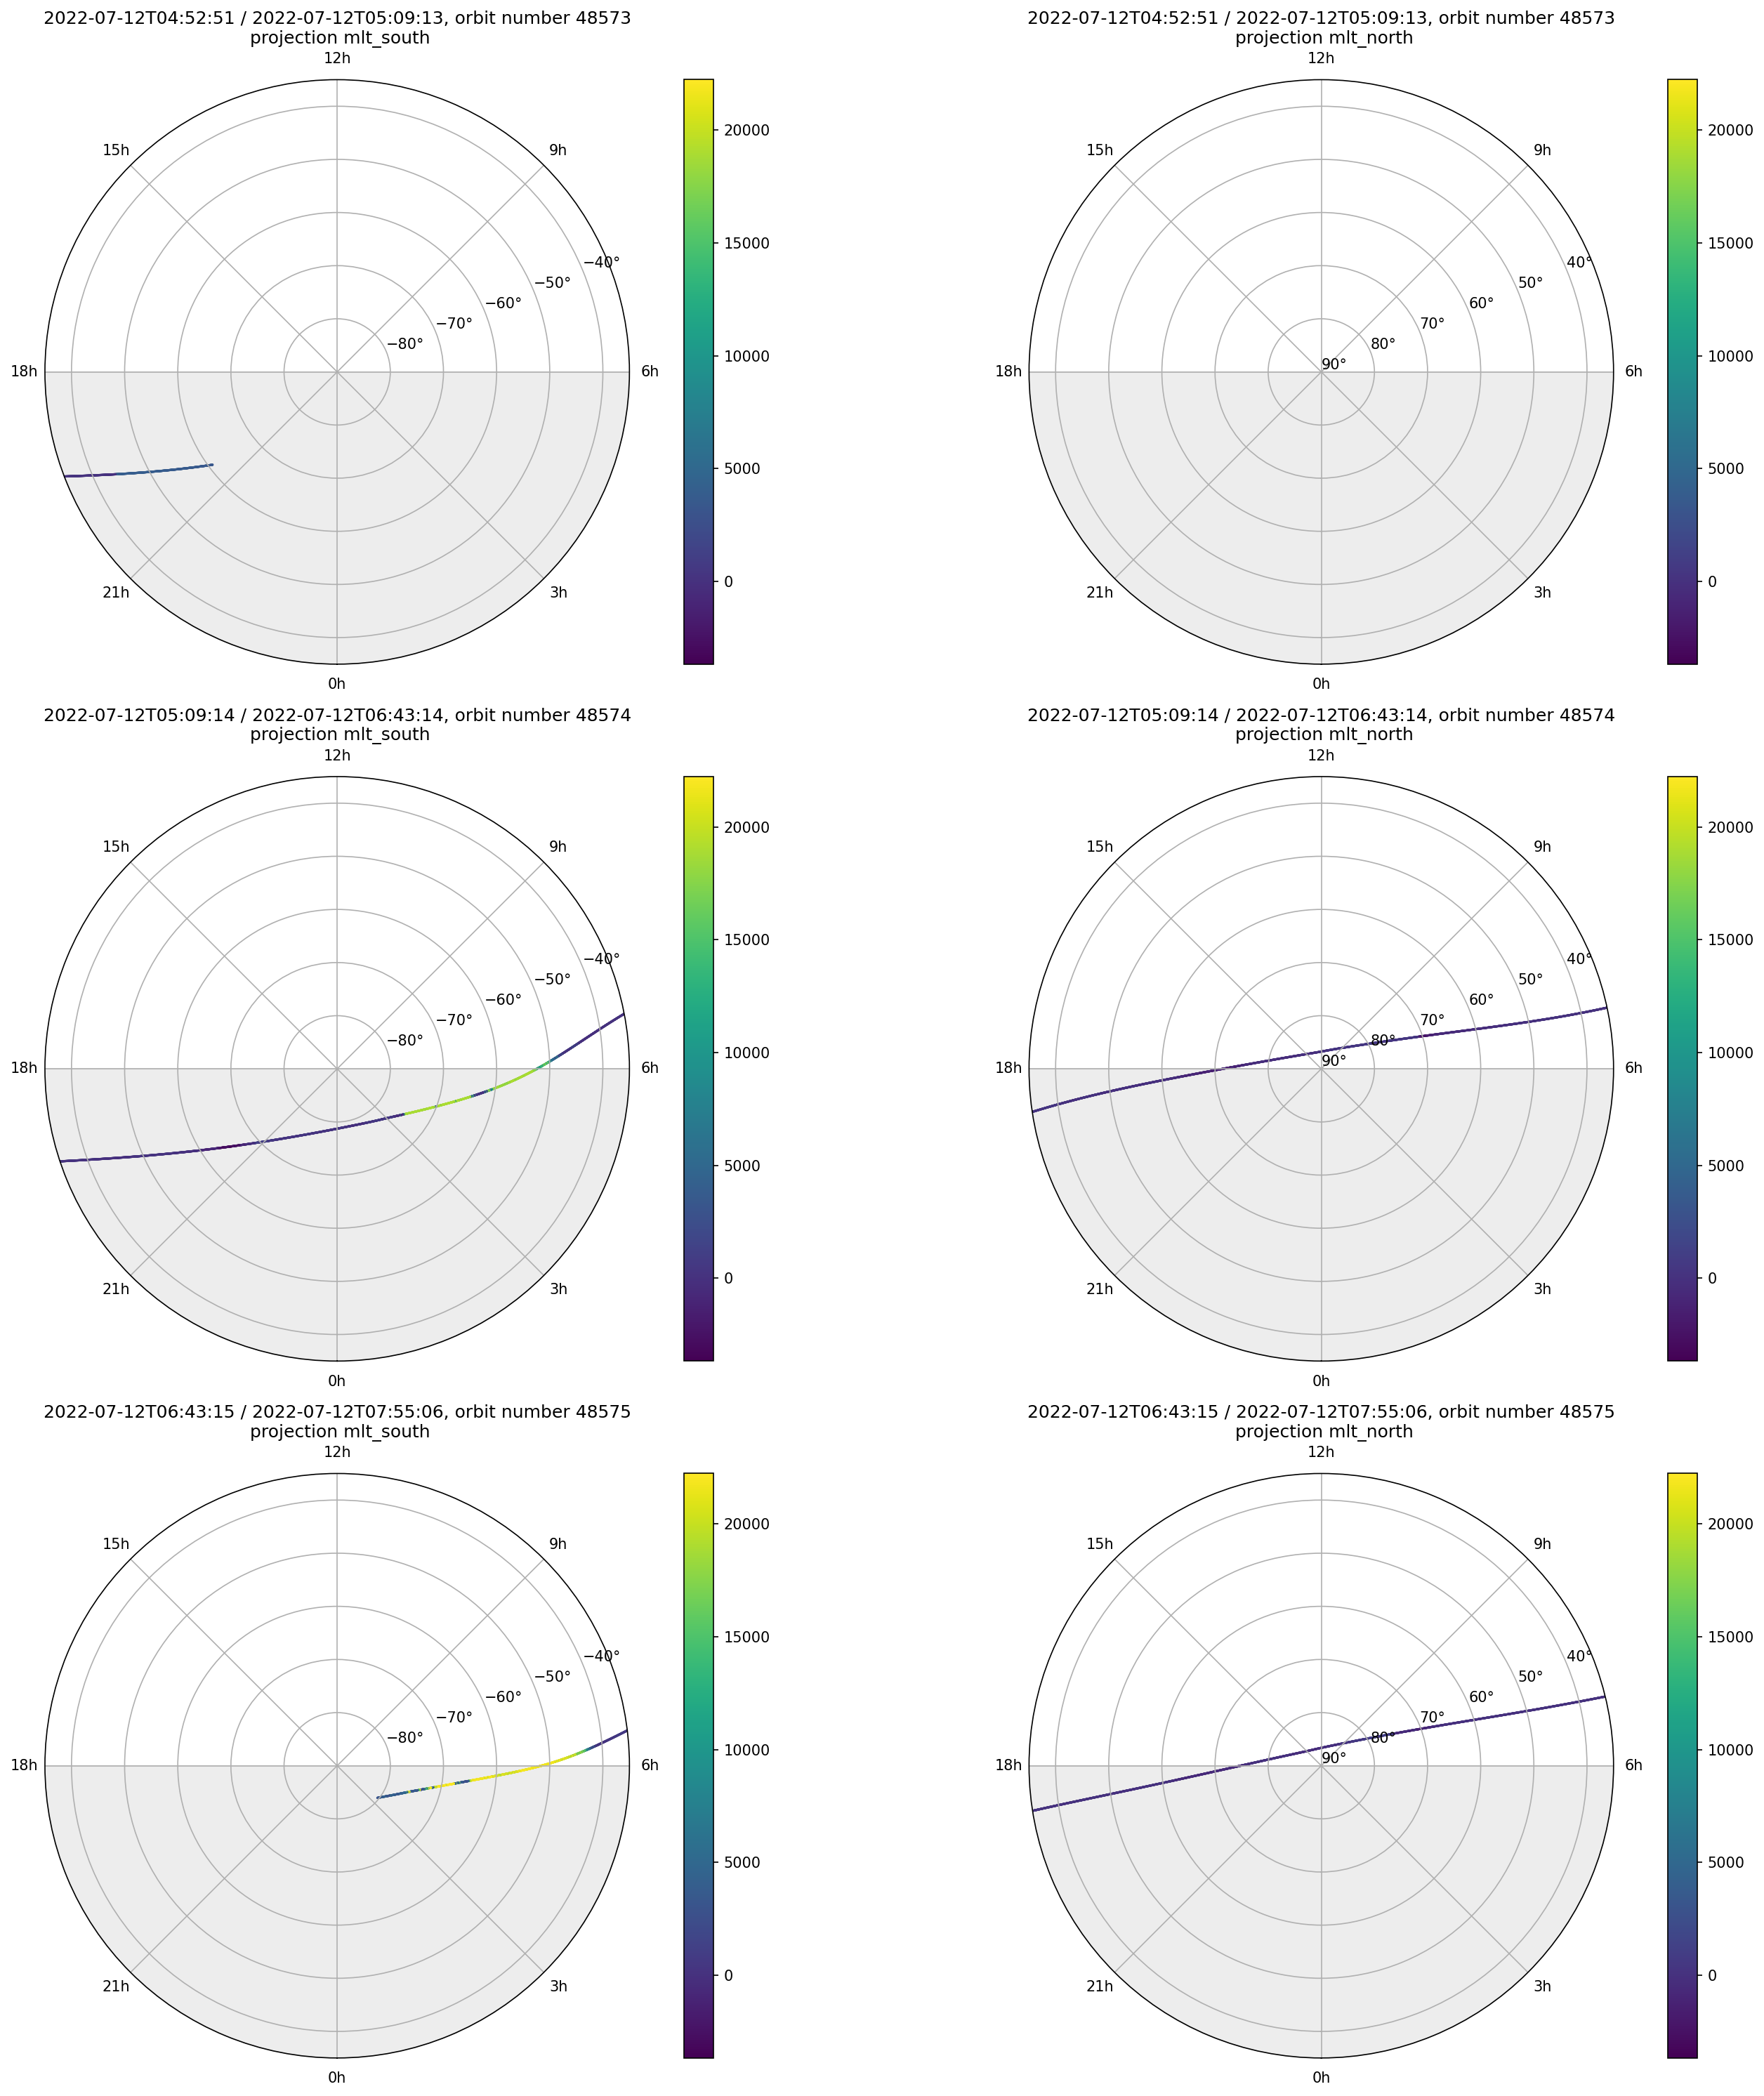

In [9]:
plot_figure(color_data_y, "viridis")

The plot demonstrate cross-track vertical ion-drift. The x-axis of each panel shows the magnetic local time in hours, while the y-axis shows the quasi-dipole latitude in degrees. The color scale is shown on a separate colorbar.

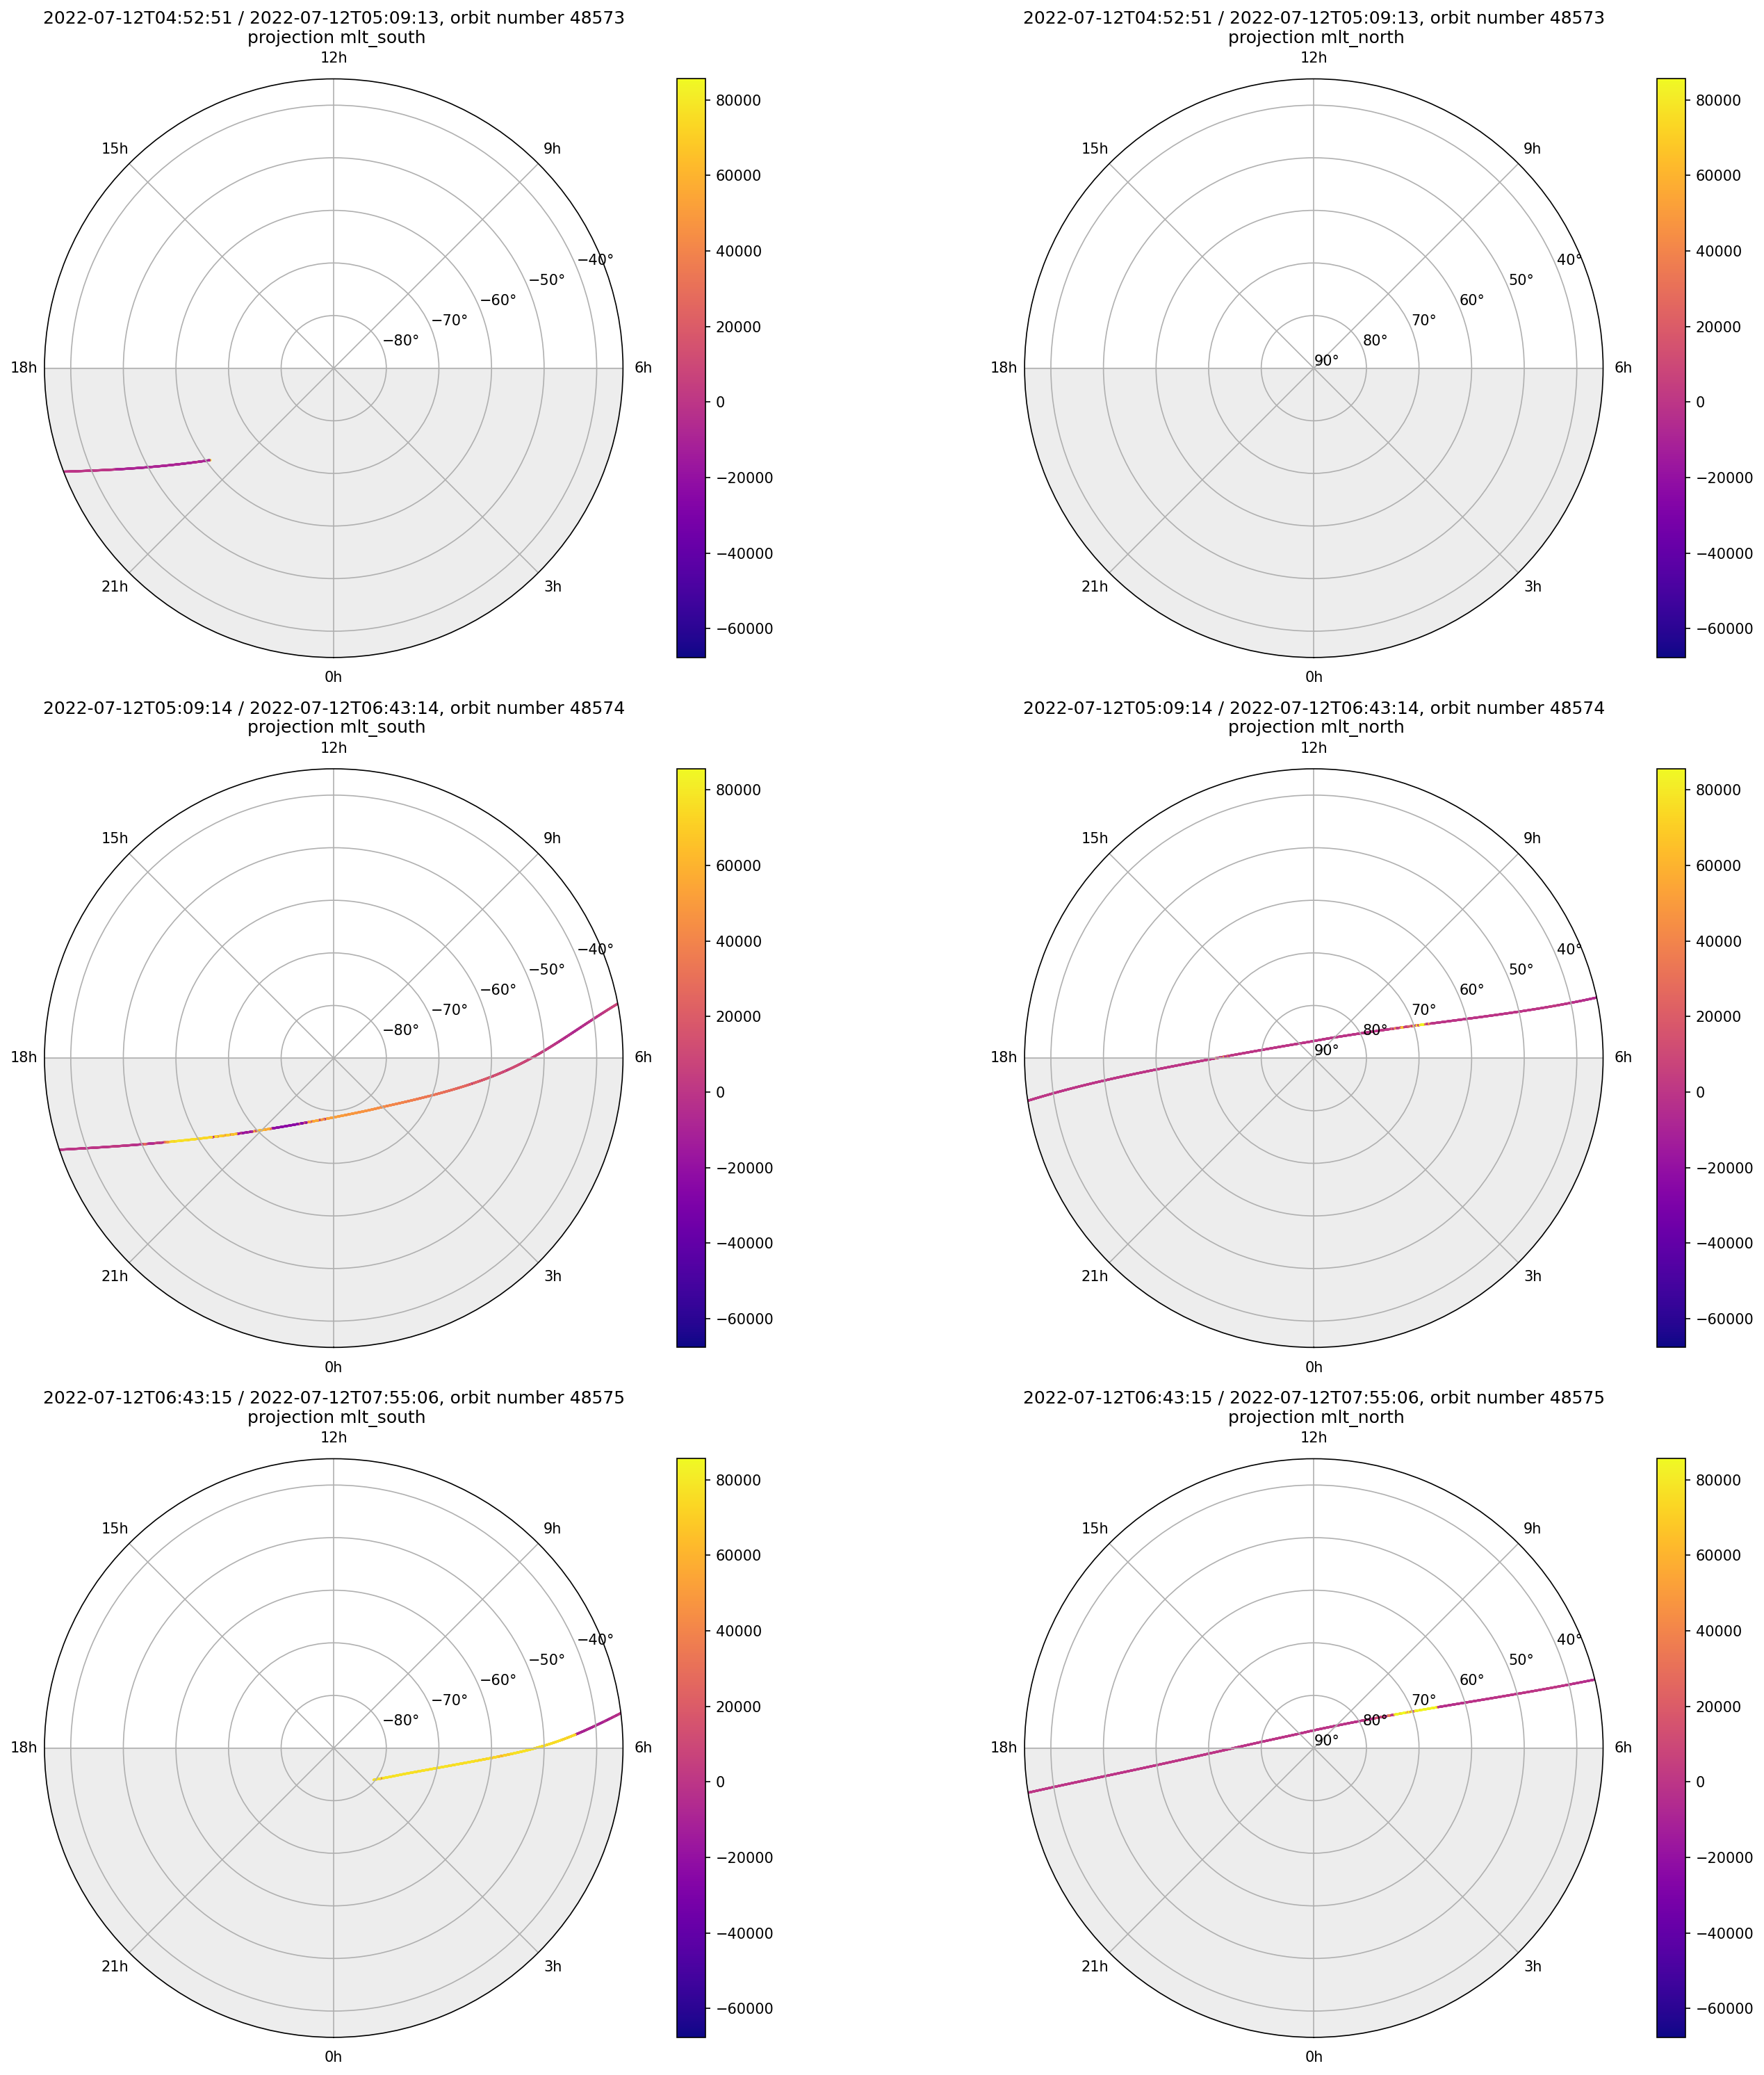

In [10]:
plot_figure(color_data_z, "plasma")

The plot demonstrate cross-track horizontal ion-drift. The x-axis of each panel shows the magnetic local time in hours, while the y-axis shows the quasi-dipole latitude in degrees. The color scale is shown on a separate colorbar.